In [53]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import os
%matplotlib inline
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
config=tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
data_set = input_data.read_data_sets('./MNIST_data/',one_hot=False)
X_train= data_set.train.images
y_train= data_set.train.labels
X_real = []
for i in range(len(y_train)):
    if y_train[i] == 6:
        X_real.append(X_train[i])

X_real = np.array(X_real)
OUTPUT_DIM = 28*28*1
batch_size = 40  # 128 # 16 # 64 128
z_dim = 64
learning_rate = 1e-4  # 0.0003 #  1e-4
epochs = 20

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


#### 判别器

In [54]:
def discriminator(images,reuse=False):
    tf.reshape(images,[-1,OUTPUT_DIM])
    with tf.variable_scope('discriminator',reuse=reuse):
        fc1 = tf.layers.dense(images,500,activation=tf.nn.relu)
        fc2 = tf.layers.dense(fc1,200,activation=tf.nn.relu)
        output = tf.layers.dense(fc2,1,activation=tf.nn.sigmoid)

    return output
    

#### 生成器

In [55]:
def generator(n_samples,reuse=False):
    z = tf.random_normal([n_samples,z_dim])
    with tf.variable_scope('generator',reuse=reuse):
        fc1 = tf.layers.dense(z,256,activation=tf.nn.relu)
        fc2 = tf.layers.dense(fc1,512,activation=tf.nn.relu)
        output = tf.layers.dense(fc2,OUTPUT_DIM,activation=tf.nn.relu)   
    return tf.reshape(output, [-1, OUTPUT_DIM])

#### 损失函数

In [56]:
def model_loss(input_real):
    g_output = generator(batch_size, reuse=False)
    d_logits_real = discriminator(input_real, reuse=False)
    d_logits_fake = discriminator(g_output, reuse=True)
    gen_cost = tf.reduce_mean(tf.log(1 - d_logits_fake))
    disc_cost = -tf.reduce_mean(tf.log(d_logits_real) + tf.log(1 - d_logits_fake))
    return disc_cost,gen_cost,d_logits_fake,d_logits_real,g_output

#### 优化器

In [57]:
def model_opt(d_loss, g_loss,global_step):
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        var_list = tf.trainable_variables()
        d_var_list = [var for var in var_list if var.name.startswith('discriminator')]
        g_var_list = [var for var in var_list if var.name.startswith('generator')]
        d_train_opt = tf.train.AdamOptimizer(1e-4).minimize(d_loss, var_list=d_var_list,
                                                                                      global_step=global_step)
        g_train_opt = tf.train.AdamOptimizer(1e-4).minimize(g_loss, var_list=g_var_list,
                                                                                      global_step=global_step)
    return d_train_opt, g_train_opt

'\n第一次创建判别器和生成器时，reuse应为False\n当reuse为False时，get_variable()表示创建变量\n当reuse为True时，get_variable()表示获取变量\n'

- 第一次创建判别器和生成器时，reuse应为False
- 当reuse为False时，get_variable()表示创建变量
- 当reuse为True时，get_variable()表示获取变量


In [58]:
# 获取输入图像
def next_batch(Xs,batch_size):
    n_batch = int(len(Xs) // batch_size)
    for i in range(n_batch):
        yield Xs[i*batch_size:(i+1)*batch_size]
        

In [59]:
# 显示图像
def show_imgs(imgs):
    for i in range(len(imgs)):
        plt.subplot(8,5,(i+1)),plt.imshow(imgs[i].reshape(28,28))
        plt.xticks([]),plt.yticks([])
    plt.show()

#### 训练函数

In [60]:
def train():
    with tf.Session() as sess:
        global_step = tf.train.get_or_create_global_step(sess.graph)
        input_real = tf.placeholder(tf.float32, [None, OUTPUT_DIM], name="input")
        d_loss, g_loss,g_score,d_score,g_out= model_loss(input_real)
        d_train_opt, g_train_opt = model_opt(d_loss, g_loss,global_step=global_step)
        sess.run(tf.global_variables_initializer())
        for i in range(epochs):
            gen = next_batch(X_real, batch_size)
            for j in range(int((len(X_real) // batch_size)//5)):
                for k in range(5):
                    _, d_cost,d_s,g_s,g_img = sess.run([d_train_opt, d_loss,d_score,g_score,g_out], feed_dict={input_real: next(gen)})
                _, g_cost= sess.run([g_train_opt, g_loss])
            print('Epoch %s/%s , d_loss %s , g_loss %s'%(i,epochs,d_cost,g_cost))
        return g_cost,d_cost,d_s,g_s,g_img

In [61]:
tf.reset_default_graph()
with tf.Graph().as_default():
    g,d,d_score,g_score,g_out= train()
    # plt.imshow(img[0].reshape(28,28))

Epoch 0/20 , d_loss 0.017213026 , g_loss -0.01570973
Epoch 1/20 , d_loss 0.013838823 , g_loss -0.008769909
Epoch 2/20 , d_loss 0.017256811 , g_loss -0.010843759
Epoch 3/20 , d_loss 0.013255691 , g_loss -0.008637361
Epoch 4/20 , d_loss 0.0019218648 , g_loss -0.0019926385
Epoch 5/20 , d_loss 0.0009450225 , g_loss -0.0029643239
Epoch 6/20 , d_loss 0.00097266276 , g_loss -0.00039429692
Epoch 7/20 , d_loss 0.00040910655 , g_loss -0.0004379171
Epoch 8/20 , d_loss 0.00030686293 , g_loss -0.00016959393
Epoch 9/20 , d_loss 0.000122799 , g_loss -0.00060105184
Epoch 10/20 , d_loss 0.0001155296 , g_loss -0.00022939141
Epoch 11/20 , d_loss 0.00034739825 , g_loss -0.00016148417
Epoch 12/20 , d_loss 7.6481454e-05 , g_loss -0.00014113492
Epoch 13/20 , d_loss 5.931945e-05 , g_loss -3.8310096e-05
Epoch 14/20 , d_loss 5.6359197e-05 , g_loss -8.4630505e-05
Epoch 15/20 , d_loss 8.134324e-05 , g_loss -4.7978836e-05
Epoch 16/20 , d_loss 4.0663155e-05 , g_loss -0.00024961488
Epoch 17/20 , d_loss 6.487682e-05 

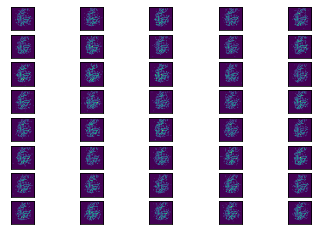

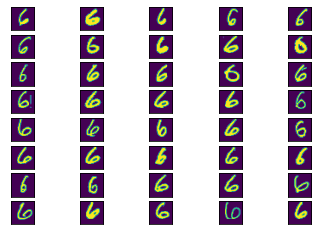

In [63]:
show_imgs(g_out)
show_imgs(X_real[0:40])
